### Ranking Comments

Ranking the comments using this model by taking the sum of toxicity score across all the 6 classes. 

In [ ]:
!pip install transformers==2.3.0

In [5]:
# from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Loading the data

In [7]:
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
import locale
locale.getpreferredencoding = getpreferredencoding

In [216]:
path = '/content/drive/MyDrive/Capstone Data/Phase 2/final_data.pkl'
train_df = pd.read_pickle(path, compression = 'gzip')

features = ['sentence_count', 'word_count', 'unique_word_count', 
            'length', 'punctuation_count', 'upper_case_count', 
            'stopword_count', '#_count', 'unique_word_count_percent', 
            'Punctuation_percent', 'ip_count','link_count', 
            'article_id_count', 'username_count', 'id']

target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat',
               'insult', 'identity_hate']
train_df = train_df.dropna()

# Seperating features and target variable
x = train_df[features]
y = train_df[target_cols]


In [180]:
len(train_df[train_df['Sum']>0])

16225

#### Supporting Functions

In [181]:
def evaluation_metrics(y_test, y_pred):
    result = {}
    result['Accuracy'] = accuracy_score(y_test, y_pred)
    result['Precision'] = precision_score(y_test, y_pred, average='weighted')
    result['Recall'] = recall_score(y_test, y_pred, average='weighted')
    result['F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    return result

#### BERT Encoding

In [182]:
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(x['clean_comment'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
# features.remove('clean_comment')
merged_x = np.hstack((attention_masks, np.array(x[features])))
merged_x.shape

In [250]:
# Splitting the data into train and test dataset
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(np.array(merged_x), np.array(y), 
                                            test_size = 0.2, random_state = 2)

In [251]:
test_ids = pd.DataFrame(test_x)[142]
test_x = np.delete(test_x, -1, axis=1)
train_x = np.delete(train_x, -1, axis=1)
test_x = np.array(test_x, dtype=float)
train_x = np.array(train_x, dtype=float)
train_y = np.array(train_y, dtype=float)
test_y = np.array(test_y, dtype=float)
no_rows = train_x.shape[0]
no_cols = train_x.shape[1]
type(test_x)

numpy.ndarray

In [252]:
from keras.models import Sequential
from keras.layers import *
print(no_rows, no_cols)
nn_model = Sequential([
    Dense(512, input_shape=(no_cols,), activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')

nn_model.summary()

127656 142
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_205 (Dense)           (None, 512)               73216     
                                                                 
 dropout_123 (Dropout)       (None, 512)               0         
                                                                 
 dense_206 (Dense)           (None, 256)               131328    
                                                                 
 dropout_124 (Dropout)       (None, 256)               0         
                                                                 
 dense_207 (Dense)           (None, 64)                16448     
                                                                 
 dropout_125 (Dropout)       (None, 64)                0         
                                                                 
 dense_208 (Dense)           (None, 32)   

### Ranking comments

In [256]:
train_y_df = pd.DataFrame(train_y)
test_y_df = pd.DataFrame(test_y)
result_df = pd.DataFrame(['Target Variable','Accuracy', 'Precision', 'Recall', 'F1 Score'])
result_list = []
pred_scores = []
all_class_scores = []
for i in range(6):
  train_target = np.array(train_y_df[i]).reshape(-1,1)
  test_target = np.array(test_y_df[i]).reshape(-1,1)
  history = nn_model.fit(train_x, train_target, epochs=10, 
                         batch_size=64, validation_data=(test_x, test_target))
  nn_pred = nn_model.predict(test_x)
  pred_scores.append(nn_pred)
  nn_pred = np.where(nn_pred > 0.5, 1, 0)
  res = evaluation_metrics(test_target,nn_pred)
  res = list(res.values())
  res.insert(0, target_cols[i])
  result_list.append(res) 

pd.DataFrame(result_list, columns=['Target Variable','Accuracy', 'Precision', 'Recall', 'F1 Score'])

Epoch 1/10
1995/1995 [==============================] - 11s 5ms/step - loss: 0.2794 - acc: 0.9089 - val_loss: 0.2817 - val_acc: 0.9077
Epoch 2/10
1995/1995 [==============================] - 11s 5ms/step - loss: 0.2789 - acc: 0.9089 - val_loss: 0.2818 - val_acc: 0.9076
Epoch 3/10
1995/1995 [==============================] - 9s 5ms/step - loss: 0.2780 - acc: 0.9093 - val_loss: 0.2814 - val_acc: 0.9072
Epoch 4/10
1995/1995 [==============================] - 9s 5ms/step - loss: 0.2781 - acc: 0.9088 - val_loss: 0.2806 - val_acc: 0.9081
Epoch 5/10
1995/1995 [==============================] - 12s 6ms/step - loss: 0.2776 - acc: 0.9089 - val_loss: 0.2844 - val_acc: 0.9070
Epoch 6/10
1995/1995 [==============================] - 10s 5ms/step - loss: 0.2779 - acc: 0.9092 - val_loss: 0.2794 - val_acc: 0.9077
Epoch 7/10
1995/1995 [==============================] - 9s 4ms/step - loss: 0.2762 - acc: 0.9093 - val_loss: 0.2791 - val_acc: 0.9084
Epoch 8/10
1995/1995 [==============================] - 10

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
1995/1995 [==============================] - 9s 4ms/step - loss: 0.1861 - acc: 0.9470 - val_loss: 0.1833 - val_acc: 0.9473
Epoch 2/10
1995/1995 [==============================] - 10s 5ms/step - loss: 0.1831 - acc: 0.9471 - val_loss: 0.1836 - val_acc: 0.9469
Epoch 3/10
1995/1995 [==============================] - 10s 5ms/step - loss: 0.1839 - acc: 0.9470 - val_loss: 0.1833 - val_acc: 0.9475
Epoch 4/10
1995/1995 [==============================] - 11s 5ms/step - loss: 0.1825 - acc: 0.9473 - val_loss: 0.1833 - val_acc: 0.9474
Epoch 5/10
1995/1995 [==============================] - 9s 5ms/step - loss: 0.1825 - acc: 0.9471 - val_loss: 0.1828 - val_acc: 0.9475
Epoch 6/10
1995/1995 [==============================] - 10s 5ms/step - loss: 0.1824 - acc: 0.9471 - val_loss: 0.1829 - val_acc: 0.9474
Epoch 7/10
1995/1995 [==============================] - 11s 5ms/step - loss: 0.1822 - acc: 0.9471 - val_loss: 0.1832 - val_acc: 0.9476
Epoch 8/10
1995/1995 [==============================] - 9

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
1995/1995 [==============================] - 10s 5ms/step - loss: 0.1847 - acc: 0.9503 - val_loss: 0.1769 - val_acc: 0.9516
Epoch 2/10
1995/1995 [==============================] - 10s 5ms/step - loss: 0.1789 - acc: 0.9504 - val_loss: 0.1748 - val_acc: 0.9516
Epoch 3/10
1995/1995 [==============================] - 9s 5ms/step - loss: 0.1770 - acc: 0.9505 - val_loss: 0.1754 - val_acc: 0.9517
Epoch 4/10
1995/1995 [==============================] - 9s 5ms/step - loss: 0.1778 - acc: 0.9501 - val_loss: 0.1743 - val_acc: 0.9513
Epoch 5/10
1995/1995 [==============================] - 11s 6ms/step - loss: 0.1759 - acc: 0.9503 - val_loss: 0.1729 - val_acc: 0.9516
Epoch 6/10
1995/1995 [==============================] - 9s 5ms/step - loss: 0.1764 - acc: 0.9501 - val_loss: 0.1739 - val_acc: 0.9516
Epoch 7/10
1995/1995 [==============================] - 9s 5ms/step - loss: 0.1755 - acc: 0.9503 - val_loss: 0.1735 - val_acc: 0.9516
Epoch 8/10
1995/1995 [==============================] - 10s

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Target Variable,Accuracy,Precision,Recall,F1 Score
0,toxic,0.908726,0.889271,0.908726,0.878182
1,severe_toxic,0.989190,0.978497,0.989190,0.983814
2,obscene,0.947329,0.923900,0.947329,0.922013
3,threat,0.997180,0.994368,0.997180,0.995772
4,insult,0.951559,0.933685,0.951559,0.928520
5,identity_hate,0.991634,0.983338,0.991634,0.987469


In [269]:
scores_df = pd.DataFrame(columns=target_cols)
for i in range(len(target_cols)):
  scores_df[target_cols[i]] = pred_scores[i].reshape(-1)

In [270]:
scores_df['overall_avg_score'] = scores_df.sum(axis=1)/6
scores_df['overall_total_score'] = scores_df[target_cols].sum(axis=1)
scores_df['ids'] = test_ids
scores_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall_avg_score,overall_total_score,ids
0,0.204895,0.006191,0.211111,0.011678,0.152558,0.003431,0.098311,0.589863,9aac578d0651fe9a
1,0.055296,0.003876,0.054304,0.003126,0.028798,0.005680,0.025180,0.151079,2cd296156c422c6b
2,0.109453,0.006395,0.036951,0.007572,0.040845,0.006566,0.034630,0.207781,a1e6bcff577bf61f
3,0.093269,0.004960,0.057267,0.005412,0.039614,0.008314,0.034806,0.208837,2192cb3732db1a6d
4,0.090145,0.002948,0.065289,0.004580,0.040477,0.003431,0.034478,0.206870,9aa0e9243d80490e
...,...,...,...,...,...,...,...,...,...
31910,0.280293,0.008060,0.152782,0.008934,0.085492,0.014571,0.091689,0.550133,68fbfc76d8bd1792
31911,0.016614,0.000370,0.010211,0.001389,0.014788,0.003431,0.007801,0.046804,df9f3649e9be1b11
31912,0.093554,0.004585,0.057074,0.002020,0.036417,0.007518,0.033528,0.201168,a420247ebf3d8d86
31913,0.092856,0.004900,0.087426,0.003225,0.036930,0.007683,0.038837,0.233021,72914eeb8d8121da


<Axes: title={'center': 'Distribution of Overall Score'}, ylabel='Frequency'>

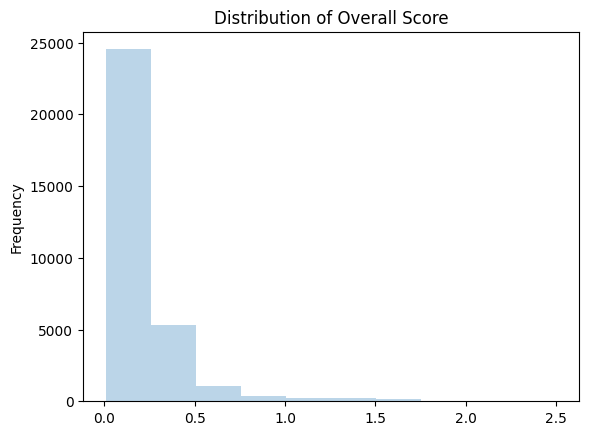

In [277]:
scores_df['overall_total_score'].plot(kind='hist', alpha=0.3,
                                      title='Distribution of Overall Score')

In [282]:
top_comment_scores = scores_df[scores_df['overall_total_score']>1.5]['overall_total_score']
print("Numbers of comments with total score greater than 1.5 :", len(top_comment_scores)) 

Numbers of comments with total score greater than 1.5 : 200


In [286]:
scores_df['Highest Score'] = False
scores_df.loc[scores_df['overall_total_score']>1.5, 'Highest Score'] = True

<Axes: title={'center': 'Distribution of Overall Score'}, ylabel='Frequency'>

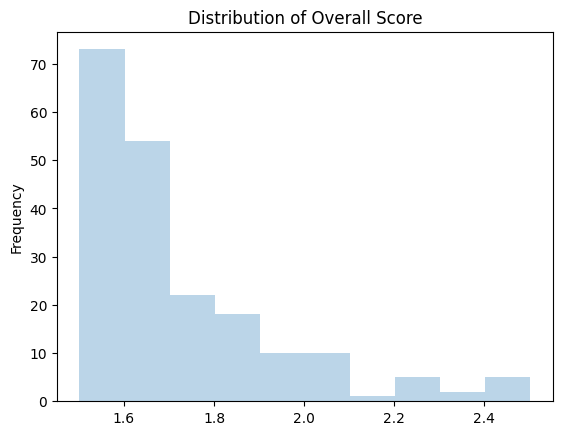

In [283]:
top_comment_scores.plot(kind='hist', alpha=0.3,
                                      title='Distribution of Overall Score')

In [283]:
import matplotlib.pyplot as plt

In [290]:
scores_df['Highest Score'] = False
scores_df.loc[scores_df['overall_total_score']>1, 'Highest Score'] = True

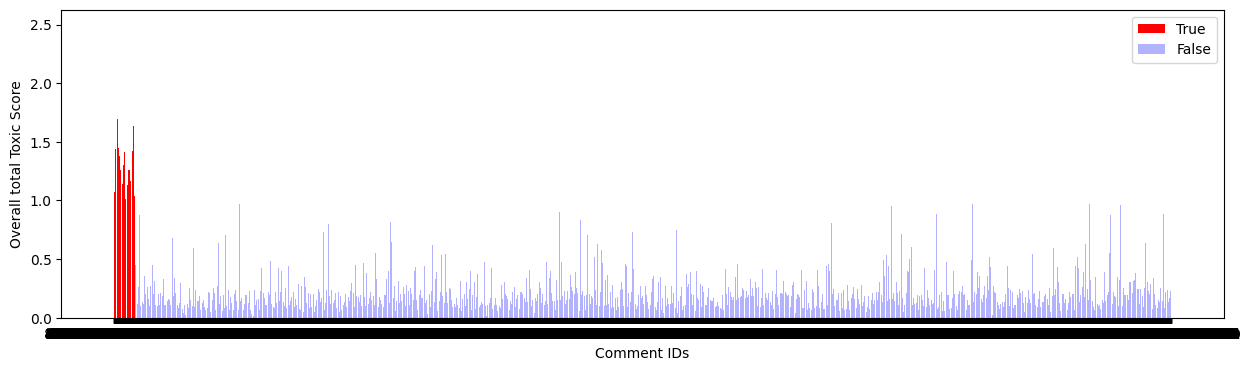

In [292]:
# create bar graph with color based on True/False column
fig, ax = plt.subplots(figsize=(15,4))
x = np.array(scores_df['ids'])
y = np.array(scores_df['overall_total_score'])
color = np.array(scores_df['Highest Score'])
ax.bar(x[color], y[color], color='red', label='True')
ax.bar(x[~color], y[~color], color='blue', label='False', alpha=0.3)
ax.legend()

# set x and y labels
ax.set_xlabel('Comment IDs')
ax.set_ylabel('Overall total Toxic Score')

# show the plot
plt.show()